In [2]:
# EduFit: Adaptive Study Companion - ML Model
# This Jupyter notebook implements the machine learning components of EduFit, including:
# - K-means clustering to identify learning styles
# - Random Forest Classifier to recommend study strategies
# - Study plan generation with curated resources and advice

In [3]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic survey data
survey_data = pd.DataFrame({
    'pref_resource': np.random.choice(['Videos', 'Podcasts', 'Practice', 'Reading'], 50),
    'daily_study_hours': np.random.choice(['Less than 1 hour', '1–2 hours', '2–3 hours', '3–4 hours', 'More than 4 hours'], 50),
    'subject': np.random.choice(['Math', 'Science', 'Other'], 50),
    'preferred_strategy': np.random.choice(['Pomodoro', 'Active Recall', 'Spaced Repetition', 'Note-Taking'], 50)
})

# Save to data/raw
survey_data.to_csv('../data/raw/survey.csv', index=False)
print("Synthetic survey data saved to data/raw/survey.csv")
print(survey_data.head())

Synthetic survey data saved to data/raw/survey.csv
  pref_resource daily_study_hours subject preferred_strategy
0      Practice         2–3 hours    Math  Spaced Repetition
1       Reading         3–4 hours    Math  Spaced Repetition
2        Videos         3–4 hours    Math      Active Recall
3      Practice  Less than 1 hour   Other      Active Recall
4      Practice         2–3 hours    Math        Note-Taking


In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load UCI dataset (first 50 records)
uci_data = pd.read_csv('../data/raw/student-mat.csv', sep=';')
uci_data = uci_data[['studytime', 'absences']].head(50)

# Handle missing values
uci_data.fillna(uci_data.mean(), inplace=True)

# Load survey data
survey_data = pd.read_csv('../data/raw/survey.csv')

# Encode categorical survey variables
pref_map = {'Videos': 1, 'Podcasts': 2, 'Practice': 3, 'Reading': 4}
hours_map = {'Less than 1 hour': 0.5, '1–2 hours': 1.5, '2–3 hours': 2.5, '3–4 hours': 3.5, 'More than 4 hours': 4.5}
subject_map = {'Math': 1, 'Science': 2, 'Other': 3}
strategy_map = {'Pomodoro': 0, 'Active Recall': 1, 'Spaced Repetition': 2, 'Note-Taking': 3}

survey_data['pref_resource'] = survey_data['pref_resource'].map(pref_map)
survey_data['daily_study_hours'] = survey_data['daily_study_hours'].map(hours_map)
survey_data['subject'] = survey_data['subject'].map(subject_map)
survey_data['preferred_strategy'] = survey_data['preferred_strategy'].map(strategy_map)

# Merge datasets
data = uci_data.copy()
data['pref_resource'] = survey_data['pref_resource'].head(50)
data['daily_study_hours'] = survey_data['daily_study_hours'].head(50)
data['subject'] = survey_data['subject'].head(50)
data['preferred_strategy'] = survey_data['preferred_strategy'].head(50)

# Normalize numerical features
scaler = StandardScaler()
data[['studytime', 'absences', 'daily_study_hours']] = scaler.fit_transform(data[['studytime', 'absences', 'daily_study_hours']])

# Save processed data
data.to_csv('../data/processed/processed_data.csv', index=False)
print("Processed data saved to data/processed/processed_data.csv")
print(data.head())

Processed data saved to data/processed/processed_data.csv
   studytime  absences  pref_resource  daily_study_hours  subject  \
0   0.085160  0.286591              3          -0.074329        1   
1   0.085160 -0.090502              4           0.668965        1   
2   0.085160  1.040776              1           0.668965        1   
3   1.504492 -0.467595              3          -1.560918        3   
4   0.085160 -0.090502              3          -0.074329        1   

   preferred_strategy  
0                   2  
1                   2  
2                   1  
3                   1  
4                   3  


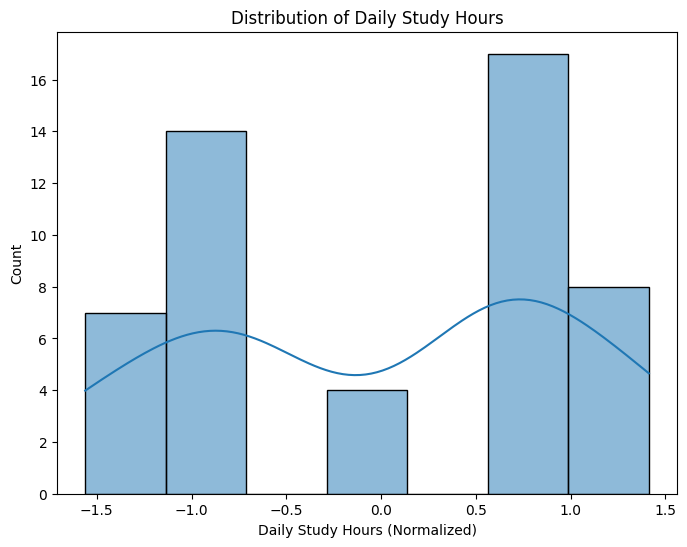

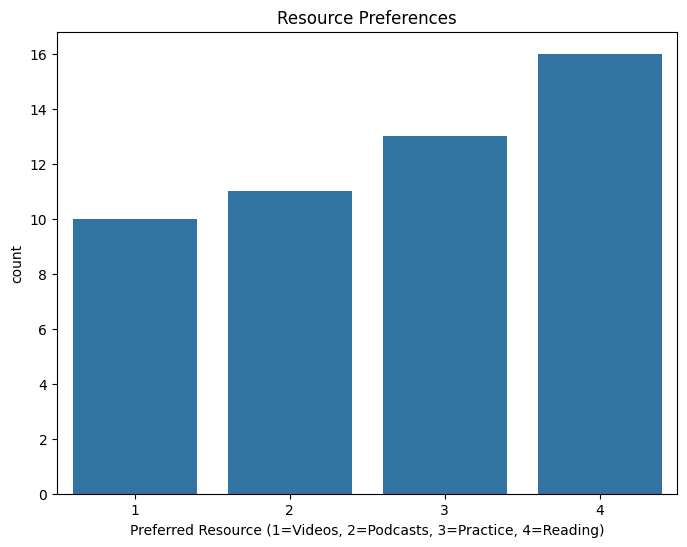

In [6]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Load processed data
data = pd.read_csv('../data/processed/processed_data.csv')

# Plot distribution of study hours
plt.figure(figsize=(8, 6))
sns.histplot(data['daily_study_hours'], kde=True)
plt.title('Distribution of Daily Study Hours')
plt.xlabel('Daily Study Hours (Normalized)')
plt.savefig('../figures/study_hours_distribution.png')
plt.show()

# Plot resource preferences
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='pref_resource')
plt.title('Resource Preferences')
plt.xlabel('Preferred Resource (1=Videos, 2=Podcasts, 3=Practice, 4=Reading)')
plt.savefig('../figures/resource_preferences.png')
plt.show()


Silhouette Score: 0.206
Clustered data saved to data/processed/data_with_clusters.csv
   studytime  pref_resource  daily_study_hours  subject learning_style_name
0   0.085160              3          -0.074329        1         Kinesthetic
1   0.085160              4           0.668965        1             Reading
2   0.085160              1           0.668965        1         Kinesthetic
3   1.504492              3          -1.560918        3             Reading
4   0.085160              3          -0.074329        1         Kinesthetic


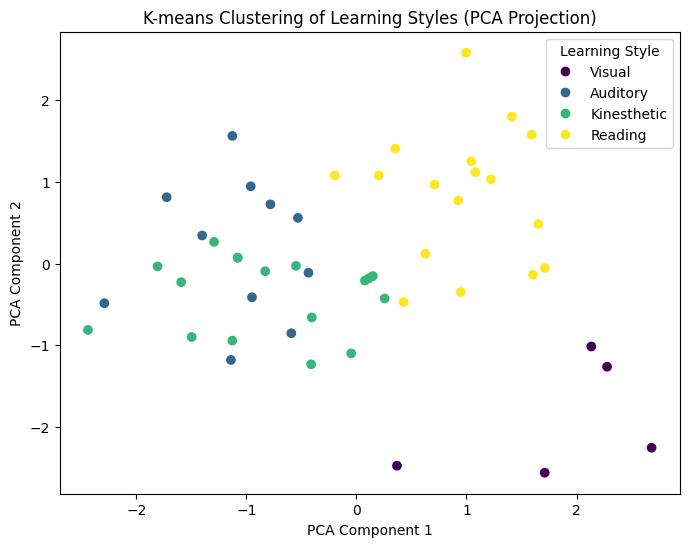

In [7]:
# K-means Clustering
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load processed data
data = pd.read_csv('../data/processed/processed_data.csv')

# Select features for clustering (exclude preferred_strategy)
features = ['studytime', 'absences', 'pref_resource', 'daily_study_hours', 'subject']
X = data[features]

# Apply K-means clustering (k=4 for visual, auditory, kinesthetic, reading)
kmeans = KMeans(n_clusters=4, random_state=42)
data['learning_style'] = kmeans.fit_predict(X)

# Calculate silhouette score
silhouette_avg = silhouette_score(X, data['learning_style'])
print(f"Silhouette Score: {silhouette_avg:.3f}")

# Map cluster labels to learning styles (for interpretation)
style_map = {0: 'Visual', 1: 'Auditory', 2: 'Kinesthetic', 3: 'Reading'}
data['learning_style_name'] = data['learning_style'].map(style_map)

# Save data with clusters
data.to_csv('../data/processed/data_with_clusters.csv', index=False)
print("Clustered data saved to data/processed/data_with_clusters.csv")
print(data[['studytime', 'pref_resource', 'daily_study_hours', 'subject', 'learning_style_name']].head())

# Visualize clusters using PCA (2D projection)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data['learning_style'], cmap='viridis')
plt.title('K-means Clustering of Learning Styles (PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(handles=scatter.legend_elements()[0], labels=['Visual', 'Auditory', 'Kinesthetic', 'Reading'], title='Learning Style')
plt.savefig('../figures/clusters.png')
plt.show()


Accuracy: 0.600

Classification Report:
                   precision    recall  f1-score   support

         Pomodoro       0.00      0.00      0.00         1
    Active Recall       0.00      0.00      0.00         1
Spaced Repetition       0.75      0.75      0.75         4
      Note-Taking       0.60      0.75      0.67         4

         accuracy                           0.60        10
        macro avg       0.34      0.38      0.35        10
     weighted avg       0.54      0.60      0.57        10

Data with predicted strategies saved to data/processed/data_with_strategies.csv
   studytime  pref_resource  daily_study_hours  subject learning_style_name  \
0   0.085160              3          -0.074329        1         Kinesthetic   
1   0.085160              4           0.668965        1             Reading   
2   0.085160              1           0.668965        1         Kinesthetic   
3   1.504492              3          -1.560918        3             Reading   
4   0.0851

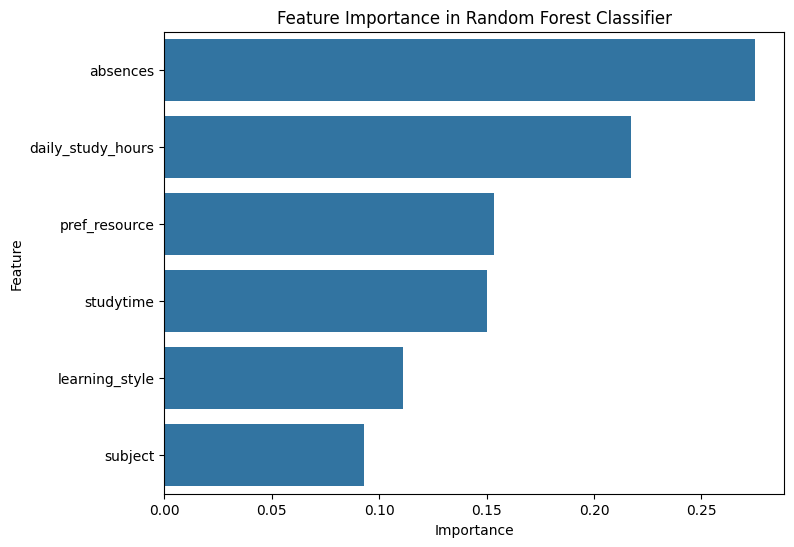

In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load clustered data
data = pd.read_csv('../data/processed/data_with_clusters.csv')

# Define features and target
features = ['studytime', 'absences', 'pref_resource', 'daily_study_hours', 'subject', 'learning_style']
X = data[features]
y = data['preferred_strategy']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on test set
y_pred = rf.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Pomodoro', 'Active Recall', 'Spaced Repetition', 'Note-Taking'], zero_division=0))

# Predict strategies for all data
data['predicted_strategy'] = rf.predict(X)

# Map numeric predictions to strategy names
strategy_map = {0: 'Pomodoro', 1: 'Active Recall', 2: 'Spaced Repetition', 3: 'Note-Taking'}
data['predicted_strategy_name'] = data['predicted_strategy'].map(strategy_map)

# Save data with predictions
data.to_csv('../data/processed/data_with_strategies.csv', index=False)
print("Data with predicted strategies saved to data/processed/data_with_strategies.csv")
print(data[['studytime', 'pref_resource', 'daily_study_hours', 'subject', 'learning_style_name', 'predicted_strategy_name']].head())

# Plot feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance in Random Forest Classifier')
plt.savefig('../figures/feature_importance.png')
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import urllib.parse
import numpy as np

# Load data
data = pd.read_csv('../data/processed/data_with_strategies.csv')

# Simulate user study topics
study_topics = ['calculus', 'physics', 'machine learning', 'biology', 'history']
np.random.seed(42)  # For reproducibility
data['study_topic'] = np.random.choice(study_topics, size=len(data))

# Define resource fetching function
def fetch_resources(learning_style, topic):
    if learning_style == 'Reading':
        # Wikipedia API
        try:
            query = urllib.parse.quote(topic)
            url = f"https://en.wikipedia.org/w/api.php?action=query&list=search&srsearch={query}&format=json"
            response = requests.get(url)
            response.raise_for_status()
            results = response.json()['query']['search']
            if results:
                title = results[0]['title']
                link = f"https://en.wikipedia.org/wiki/{urllib.parse.quote(title)}"
                return f"Wikipedia: {title} ({link})"
            return "Wikipedia: No article found"
        except Exception as e:
            return f"Wikipedia: Error fetching article ({str(e)})"
    elif learning_style == 'Visual':
        # Curated video links
        topic_map = {
            'calculus': "Khan Academy: Calculus (https://www.khanacademy.org/math/calculus-1)",
            'physics': "CrashCourse: Physics (https://www.youtube.com/playlist?list=PL8dPuuaLjXtN0ge7yDk_UA0ldZJdhwkoV)",
            'machine learning': "freeCodeCamp: Machine Learning (https://www.youtube.com/watch?v=Eo9L-TWFZ3I)",
            'biology': "Bozeman Science: Biology (https://www.youtube.com/user/bozemanscience)",
            'history': "CrashCourse: World History (https://www.youtube.com/playlist?list=PLBDA2E52FB1EF80C9)"
        }
        return topic_map.get(topic, "Khan Academy: General (https://www.khanacademy.org)")
    elif learning_style == 'Auditory':
        # Curated podcast links
        topic_map = {
            'calculus': "The Math Factor: Math Topics (http://mathfactor.uark.edu)",
            'physics': "StarTalk Radio: Physics (https://www.startalkradio.net)",
            'machine learning': "Data Skeptic: Machine Learning (https://dataskeptic.com)",
            'biology': "This Week in Science: Biology (https://www.twis.org)",
            'history': "History Extra: World History (https://www.historyextra.com/podcasts)"
        }
        return topic_map.get(topic, "BBC Learning: General (https://www.bbc.co.uk/programmes/p02nrsln)")
    elif learning_style == 'Kinesthetic':
        # Curated simulation links
        topic_map = {
            'calculus': "GeoGebra: Calculus (https://www.geogebra.org/calculus)",
            'physics': "PhET: Physics Simulations (https://phet.colorado.edu/en/simulations/category/physics)",
            'machine learning': "TensorFlow Playground: ML (https://playground.tensorflow.org)",
            'biology': "PhET: Biology Simulations (https://phet.colorado.edu/en/simulations/category/biology)",
            'history': "Smithsonian Learning Lab: History (https://learninglab.si.edu)"
        }
        return topic_map.get(topic, "PhET: General (https://phet.colorado.edu)")
    return "No resources available"

# Define advice mapping
advice_map = {
    'Pomodoro': 'Study in 25-minute sessions with 5-minute breaks. Use Focus Booster.',
    'Active Recall': 'Test yourself with flashcards. Try Anki (https://apps.ankiweb.net).',
    'Spaced Repetition': 'Review material at intervals. Use Quizlet (https://quizlet.com).',
    'Note-Taking': 'Use Cornell Notes. Summarize key points after sessions.'
}

# Generate resources and advice
data['resources'] = data.apply(lambda row: fetch_resources(row['learning_style_name'], row['study_topic']), axis=1)
data['advice'] = data['predicted_strategy_name'].map(advice_map)

# Select columns
study_plans = data[['learning_style_name', 'predicted_strategy_name', 'study_topic', 'resources', 'advice']]

# Save
study_plans.to_csv('../data/processed/final_study_plans.csv', index=False)
print("Study plans saved to data/processed/final_study_plans.csv")
print(study_plans.head())

# Strategy distribution plot
plt.figure(figsize=(8, 6))
sns.countplot(data=study_plans, x='predicted_strategy_name')
plt.title('Distribution of Recommended Study Strategies')
plt.xlabel('Recommended Strategy')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.savefig('../figures/strategy_distribution.png')
plt.show()